# Multiple Query PRM APF Planner

Importing all required libraries and defining all required variables

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from matplotlib.path import Path

N_nodes = 100 # Number of sampled nodes
N_knn = 3 # Number of neighbors considered for each node 
connections = [] # List of connections between nodes


Defining the following utility functions: 
- `dist(q1,q2)` to compute the distance between two nodes $q_1$ and $q_2$
- `knn(q,Q,k)` to find $k$ nearest neighbors of $q$ in $Q$
- `checkPoints(Q,obs)` to check the validity of the points in $Q$ (i.e., whether or not they lie within an obstacle)
- `checkCollision(q1,q2,obs)` to check the collision between two nodes $q_1$ and $q_2$
- `connectNeighbors(q,Q_valid,color)` to connect $q$ to all its neighboring nodes if there is no collision

In [2]:
def dist(q1,q2):
    return (q1[0]-q2[0])**2 + (q1[1]-q2[1])**2

def knn(q,Q,k):
    dists = [dist(q,p) for p in Q if p != q]
    return [Q[i] for i in np.argsort(dists)[:k]]

def apf(q1,q2):
    pass

def checkPoints(Q,obs):
    checks = np.full(len(Q),1)
    # check if point lies within the obstacle 
    for obstacle in obs:
        p = Path(obstacle)  
        bool = p.contains_points(Q)
        for i in range(len(bool)):
            if bool[i] == True:
                checks[i] = 0
    return checks

def checkCollision(q1, q2, obs):
    sx, sy = q1[0], q1[1]
    ex, ey = q2[0], q2[1]

    for obstacle in obs:
        p = Path(obstacle)
        for i in range(100):
            u = i / 100
            x = sx * u + ex * (1 - u)
            y = sy * u + ey * (1 - u)
            if p.contains_point((x, y)):
                return True
    return False

def connectNeighbors(q,Q_valid,color):
    global connections 
    for q_n in knn(q,Q_valid,N_knn):
        if (not checkCollision(q, q_n, obstacles) and ((q,q_n) or (q_n,q) not in connections)):
            connections.append((q, q_n))
            ax.plot([q[0], q_n[0]], [q[1], q_n[1]], color = color)
    

Setting up the plot and populating it with obstacles 

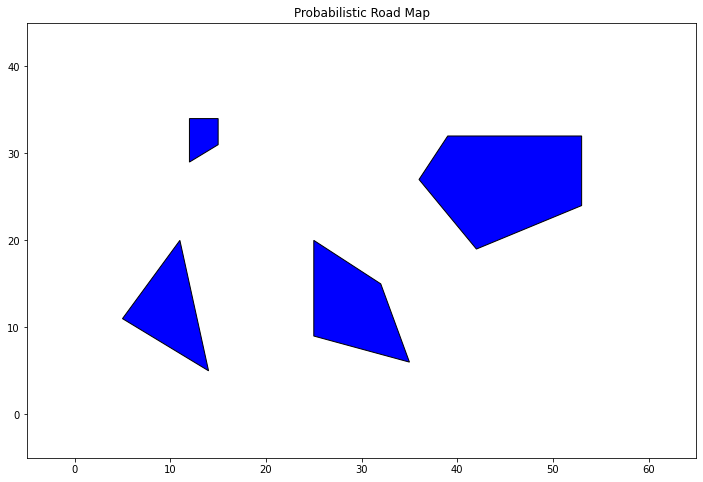

In [3]:
plt.rcParams['figure.figsize'] = (12, 8)
x = np.linspace(0, 60, 10)
y = np.linspace(0, 40, 10)
fig,ax = plt.subplots()

ax.set_title('Probabilistic Road Map')

obstacles = []
with open("obstacles.txt") as f:
    for line in f:
        coord_arr = []
        vertices_arr = line.split()
        # join each 2 consecutive values and form an array of coordinates
        for i in range(0, len(vertices_arr), 2):
            coord_arr.append((int(vertices_arr[i]), int(vertices_arr[i+1])))
        p = Polygon(coord_arr, facecolor = 'blue', edgecolor = 'black')
        ax.add_patch(p)
        ax.set_xlim([-5, 65])
        ax.set_ylim([-5, 45])
        obstacles.append(coord_arr)

## Checkpoint 1: 
Construct the roadmap and show the graph on matplotlib. Show the sampled nodes in green, nodes that were rejected as red, obstacles as blue. Also connect the nodes that share a edge using straight lines.

In [4]:
# A list of coordinates that are chosen randomly 
Q = [(np.random.randint(0,60), np.random.randint(0,40)) for _ in range(N_nodes)]

check = checkPoints(Q,obstacles)

Q_valid = []
for point in Q:
    if check[Q.index(point)] == 1:
        Q_valid.append(point)
        ax.scatter(point[0], point[1], color = 'green', marker = 'o', s = 25)
    else:
        ax.scatter(point[0], point[1], color = 'red', marker = 'o', s = 25)

for q in Q_valid:
    connectNeighbors(q,Q_valid,'green')


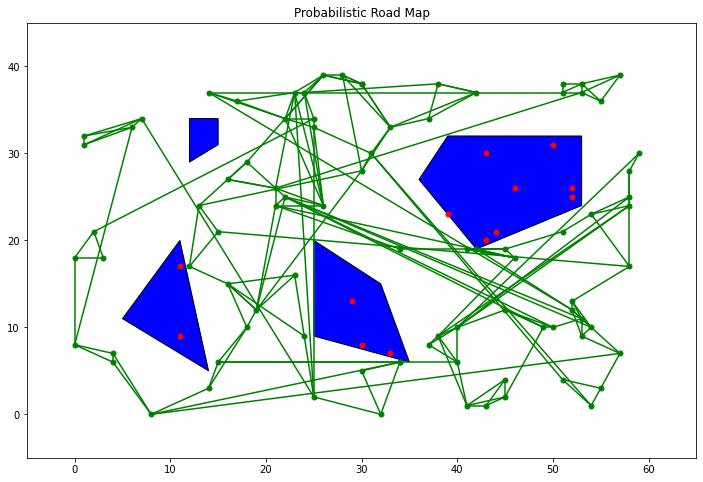

In [5]:
fig

## Checkpoint 2:
Augment the start and the goal point to the roadmap. Mark these points using a separate color. Show the graph on matplotlib again as described above. Then apply Dijkstra or A∗ search to find a path from the start to the goal point. Mark the edges that constitute the path in some other color. Repeat for all queries in the file

$A*$ algorithm to find the shortest path from the start to the goal point

In [6]:
def a_star(start,goal,Q_v,obstacles):
    parent = np.zeros((len(Q_v),len(Q_v),2),dtype=np.uint8) # Keeping track of the parent nodes
    visited = []  # Keeping a list of visited nodes so that we dont visit the same node again
    current = start
    distance = np.full((len(Q_v),len(Q_v)),np.inf)
    distance[start] = 0

        # Loop runs until we reach the target 
    while True:
        if current != goal:
            for q_n in knn(current,Q_v,N_knn):
                if (not checkCollision(current, q_n, obstacles)):
                    if distance[q_n] > distance[current] + dist(q_n, current) + dist(q_n, goal):
                        distance[q_n] = distance[current] + dist(q_n, current)+ dist(q_n,goal)
                        parent[q_n] =  current
                        visited.append(q_n)
                # Choosing the node with the least current distance for analysis in the next cycle
                min = np.inf
            for point in visited:
                if distance[point] < min:
                    min = distance[point]
                    current = point
            if not len(visited):
                return None, None
            else:
                visited.remove(current)
        else:
            distance[goal] = distance[current] +dist(goal, current)
            return distance[goal], parent
    
     


In [8]:
starts = []
goals = []
with open("queries.txt") as f:
    for line in f:
        # first 2 numbers represent coordinate of start, last 2 numbers represent coordinate of goals
        coords = line.split()
        # join each 2 consecutive values and form an array of coordinates
        starts.append((int(coords[0]), int(coords[1])))
        goals.append((int(coords[2]), int(coords[3])))

for start, goal in zip(starts, goals):
    ax.scatter(start[0], start[1], color = 'orange',marker='x',  s = 50)
    ax.scatter(goal[0], goal[1], color = 'cyan',marker='x', s = 50)

    q_n_start = knn(start, Q_valid, N_knn)
    connectNeighbors(start,Q_valid,'orange')

    q_n_goal = knn(goal, Q_valid, N_knn)
    connectNeighbors(goal,Q_valid,'cyan')

    Q_valid.append(start)
    Q_valid.append(goal)

    distance, parent = a_star(start, goal, Q_valid, obstacles)

    #print(f"Parent goal is:{parent[goal]}")
    if distance is None:
        print("No path found")
    else:
        path = []
        current = goal
        path.append(current)
        #print(current, start)
        while (np.array(current) != np.array(start)).all():
            current = tuple(parent[current])
            path.append(current)
        path.reverse()

        for point in path: 
            for i in range(len(path)-1):        
                ax.plot([path[i][0], path[i+1][0]], [path[i][1], path[i+1][1]], color = 'yellow', linewidth = 3)



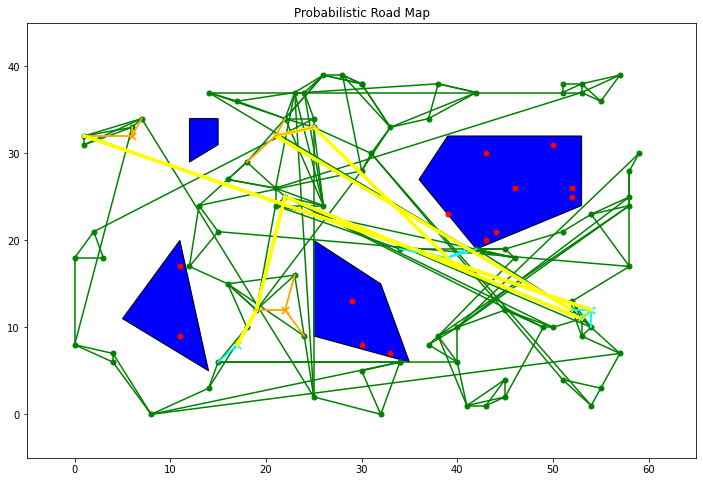

In [9]:
fig

## Checkpoint 3:
Divide the map into a grid (each square should be of 0.0625 sq units) and show it (use any method you want, we just want to look at it). Mark a grid square as blocked if it’s centre lies inside an obstacle. Else mark it free. Color all blocked grid square as black, rest as white. (Do all this in a separate image/plot, don’t make the previous plot cluttered).

## Checkpoint 4: 
Apply Brushfire or the Wavefront Planner and find out the distances of each grid square from the obstacles. Use these distances for planning a path locally. Create an animation, or mark the path in the grid.